In [1]:
import numpy as np
import matplotlib.pyplot as plt

import keras

Using TensorFlow backend.
C:\Users\Sepehr\AppData\Local\conda\conda\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Custom callbacks

Define your own callback by sub-classing the class **keras.callbacks.Callback** .

Available methods:
1. on_epoch_begin
2. on_epoch_end
3. on_batch_begin
4. on_batch_end
5. on_train_begin
6. on_train_end

These methods are called with a *logs* argument: a dictionary containing information about the previous batch, epoch, or training run.

Every callback object has access to these attributes about the model:
1. self.model
2. self.validation_data

A general pattern for defining custom callbacks is as follows:

In [ ]:
class My_Callback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        pass
 
    def on_train_end(self, logs={}):
        pass
 
    def on_epoch_begin(self, epoch, logs={}):
        pass
 
    def on_epoch_end(self, epoch, logs={}):
        pass
 
    def on_batch_begin(self, batch, logs={}):
        pass
 
    def on_batch_end(self, batch, logs={}):
        pass

# Custom callback example

Here’s a simple example of a custom callback that saves to disk (as Numpy arrays) the
activations of first layer of the model at the end of every epoch, computed on the
first sample of the validation set:

In [18]:
class ActivationLogger(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        layer_output = self.model.layers[1].output
        
        # Model instance that returns the activations of first layer
        self.activations_model = keras.models.Model(self.model.input, layer_output)
        print('Activations model initialized successfully.')
        
    def on_epoch_end(self, epoch, logs=None):
        if self.validation_data is None:
            raise RuntimeError('Requires validation_data.')
            
        # Obtain the first input sample of the validation data
        validation_sample = self.validation_data[0][0:1]
        
        # Compute activations
        activations = np.array(self.activations_model.predict(validation_sample))
        
        # Save arrays to disc
        file_name = 'activations_at_epoch_' + str(epoch) + '.npz'
        np.savez(file_name, activations)
        print('Activations saved to disc.')

## Prepare MNIST data

In [25]:
from keras.datasets import mnist
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = (x_train / 255).astype('float32')
x_test = (x_test / 255).astype('float32')

x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]

print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

y_train = to_categorical(y_train)
num_classes = y_train.shape[1]

x_train shape:  (60000, 28, 28, 1)
x_test shape:  (10000, 28, 28, 1)


## Define a simple model

In [26]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, 3, input_shape=(28, 28, 1), activation='relu'))
model.add(keras.layers.Conv2D(64, 3, input_shape=(28, 28, 1), activation='relu'))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(64, 3, input_shape=(28, 28, 1), activation='relu'))
model.add(keras.layers.Conv2D(32, 3, input_shape=(28, 28, 1), activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 6, 6, 64)          36928     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 4, 4, 32)          18464     
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total para

## Compile the model

In [27]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001, rho=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

## Fit the model

In [28]:
activation_logger = ActivationLogger()
model.fit(x_train, y_train, batch_size=64, epochs=20, validation_split=0.2, callbacks=[activation_logger])

Train on 48000 samples, validate on 12000 samples
Activations model initialized successfully.
Epoch 1/20
48000/48000 [==============================] - 86s 2ms/step - loss: 0.7060 - acc: 0.8010 - val_loss: 0.2731 - val_acc: 0.9197
Activations saved to disc.
Epoch 2/20
48000/48000 [==============================] - 88s 2ms/step - loss: 0.2312 - acc: 0.9306 - val_loss: 0.1618 - val_acc: 0.9529
Activations saved to disc.
Epoch 3/20
48000/48000 [==============================] - 90s 2ms/step - loss: 0.1414 - acc: 0.9581 - val_loss: 0.1152 - val_acc: 0.9660
Activations saved to disc.
Epoch 4/20
48000/48000 [==============================] - 86s 2ms/step - loss: 0.1043 - acc: 0.9694 - val_loss: 0.0924 - val_acc: 0.9745
Activations saved to disc.
Epoch 5/20
48000/48000 [==============================] - 84s 2ms/step - loss: 0.0850 - acc: 0.9748 - val_loss: 0.0811 - val_acc: 0.9763
Activations saved to disc.
Epoch 6/20
48000/48000 [==============================] - 85s 2ms/step - loss: 0.0724 

## Plot activations for epoch 0 and 10

In [52]:
def plot_first_25(arr):
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.matshow(arr[0][:, :, i])

In [53]:
e_0 = np.load('activations_at_epoch_0.npz')
arr = e_0.get('arr_0')

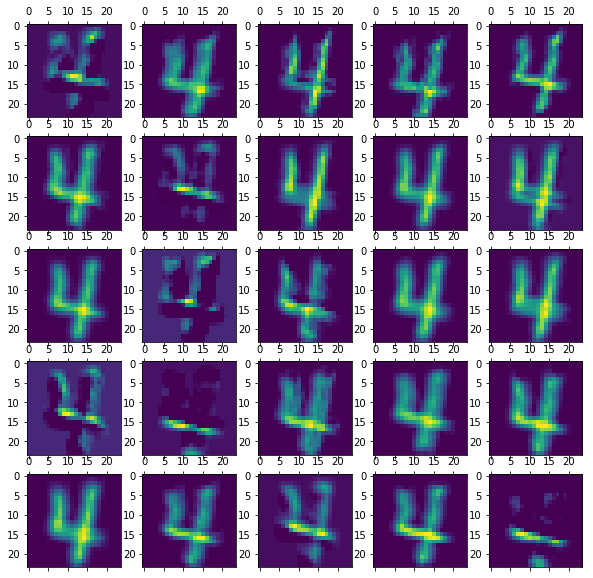

In [54]:
plot_first_25(arr)

In [60]:
e_10 = np.load('activations_at_epoch_10.npz')
arr = e_10.get('arr_0')

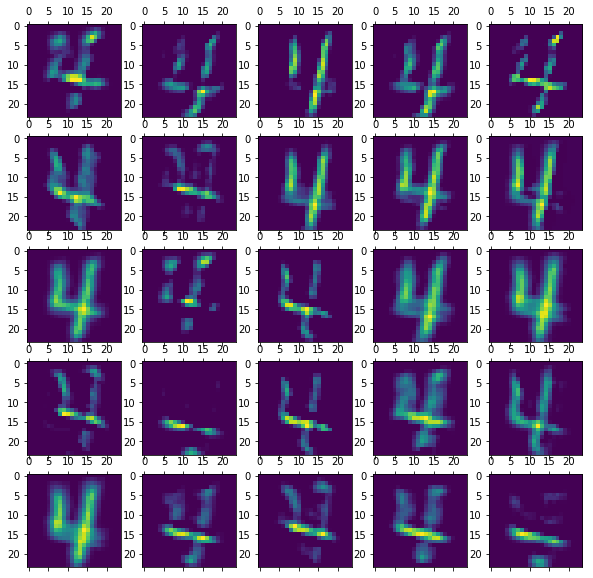

In [61]:
plot_first_25(arr)